## Train QuickNAT
Working code! Details coming soon!

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.data_utils import get_data

from quickNat_pytorch.net_api import squeeze_excitation as se

#torch.set_default_tensor_type('torch.FloatTensor')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

params ={
    'data' : {
        'base_dir' : "datasets/coronal",
        'train_data_file' : "Data_train.h5", 
        'train_label_file' : "Label_train.h5",
        'train_class_weights_file' : "Class_Weight_train.h5",        
        'train_weights_file' : "Weight_train.h5",                
        'test_data_file' : "Data_test.h5", 
        'test_label_file' : "Label_test.h5",         
        'test_class_weights_file' : "Class_Weight_test.h5",       
        'test_weights_file' : "Weight_test.h5"        

    },
    'network' : { 
        'num_class': 33,
        'num_channels':1,
        'num_filters':64,
        'kernel_h':5,
        'kernel_w':5,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'se_block' : se.SELayer.NONE, # Valid options : se.SELayer.NONE, se.SELayer.CSE, se.SELayer.SSE, se.SELayer.CSSE
        'drop_out' : 0.2 # Keep 0 for no dropout        
    },
    'training' : {
        'learning_rate': 1e-2,
        'train_batch_size': 2,
        'val_batch_size': 5,
        'log_nth': 50,
        'num_epochs': 10,
        'lr_scheduler_step_size': 5,
        'lr_scheduler_gamma' : 0.5,
        'exp_dir_name': 'Exp02_try3',
        'final_model_path': 'models/quicknat_model.model',        
    }
}

train_params, net_params, data_params = params['training'], params['network'], params['data']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [7]:
train_data, test_data = get_data(data_params)
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

Train size: 1320
Test size: 1320


## Train Model

In [10]:
from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_params['train_batch_size'], shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=train_params['val_batch_size'], shuffle=False, num_workers=4)

quicknat_model = quickNAT(params['network'])
solver = Solver(optim_args={"lr": train_params['learning_rate']})
solver.train(quicknat_model, train_loader, val_loader, 
             log_nth=train_params['log_nth'], 
             num_epochs=train_params['num_epochs'], 
             exp_dir_name=train_params['exp_dir_name'], 
             lr_scheduler_step_size = train_params['lr_scheduler_step_size'], 
             lr_scheduler_gamma = train_params['lr_scheduler_gamma'])

START TRAIN.


RuntimeError: running_mean should contain 1 elements not 64

## Save the Model

When you are satisfied with your training, you can save the model.

In [15]:
quicknat_model.save(train_params['final_model_path'])

Saving model... models/Exp02_try3/quicknat_model.model


## Deploy Model on Test Data

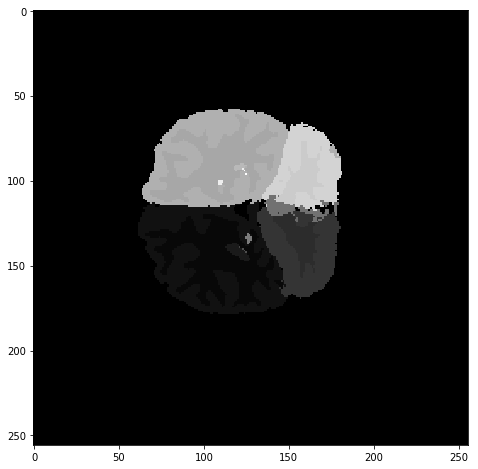

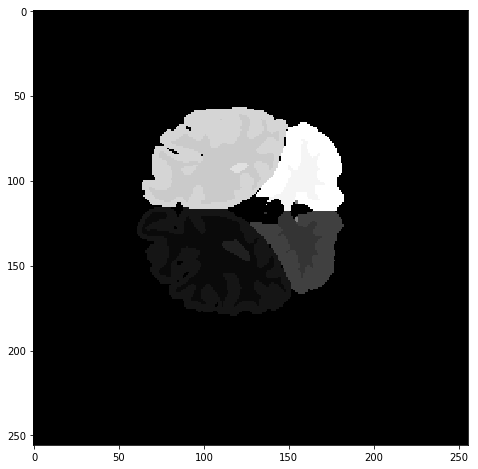

In [16]:
import matplotlib.pyplot as plt

quick_model = torch.load(train_params['final_model_path'])
quick_model = quick_model.eval()
with torch.no_grad():
    test_input = Variable(torch.Tensor(test_data.X[200:201]).cuda())
#quick_model.enable_test_dropout()
out = quick_model(test_input)
max_val, idx = torch.max(out,1)
idx = idx.data.cpu().numpy()
idx = np.squeeze(idx)
plt.imshow(idx)
plt.show()

img_test = test_data.y[201:202]
img_test = np.squeeze(img_test)
plt.imshow(img_test)
plt.show()